# Earthquake Bot — Profit Dashboard

Источник истины: **Polymarket API** (on-chain баланс + positions + activity)

In [1]:
import json
import urllib.request
from datetime import datetime, timezone

In [2]:
# Получить текущий баланс USDC.e с блокчейна
import urllib.request

WALLET = '0xff36fc6De4CCDd290C14EE69244c21c1803Ad5b7'
USDC_E = '0x2791Bca1f2de4661ED88A30C99A7a9449Aa84174'

# balanceOf(address) call
selector = '0x70a08231'
padded = WALLET[2:].lower().zfill(64)
call_data = selector + padded

RPCS = ['https://polygon-rpc.com', 'https://polygon-bor-rpc.publicnode.com', 'https://rpc.ankr.com/polygon']

current_balance = None
for rpc in RPCS:
    try:
        payload = json.dumps({
            'jsonrpc': '2.0', 'id': 1, 'method': 'eth_call',
            'params': [{'to': USDC_E, 'data': call_data}, 'latest']
        }).encode()
        req = urllib.request.Request(rpc, data=payload,
                                     headers={'Content-Type': 'application/json', 'User-Agent': 'Mozilla/5.0'})
        resp = json.loads(urllib.request.urlopen(req, timeout=10).read())
        current_balance = int(resp['result'], 16) / 1e6
        print(f'USDC.e balance: ${current_balance:.2f}  (via {rpc.split("//")[1].split("/")[0]})')
        break
    except Exception as e:
        print(f'{rpc}: {e}')

if current_balance is None:
    raise RuntimeError('Cannot fetch balance from any RPC')

https://polygon-rpc.com: HTTP Error 401: Unauthorized
USDC.e balance: $793.94  (via polygon-bor-rpc.publicnode.com)


In [3]:
# Реальные депозиты (переводы с основного аккаунта)
DEPOSITS = [230.41, 99.50, 1044.98, 198.71, 249.94, 227.16, 209, 167.29]
total_deposits = sum(DEPOSITS)
print(f'Total deposits: ${total_deposits:.2f}')

Total deposits: $2426.99


In [4]:
# ══════════════════════════════════════════════════════════════
# POLYMARKET API — PROFIT DASHBOARD (источник истины)
# ══════════════════════════════════════════════════════════════

# --- 1. Все трейды с Polymarket ---
all_trades = []
offset = 0
while True:
    url = f'https://data-api.polymarket.com/activity?user={WALLET}&limit=100&offset={offset}'
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    batch = json.loads(urllib.request.urlopen(req, timeout=15).read())
    if not batch:
        break
    all_trades.extend(batch)
    offset += 100
    if len(batch) < 100:
        break

buys  = [t for t in all_trades if t.get('side') == 'BUY'  and t['type'] == 'TRADE']
sells = [t for t in all_trades if t.get('side') == 'SELL' and t['type'] == 'TRADE']
redeems = [t for t in all_trades if t['type'] == 'REDEEM']
rewards = [t for t in all_trades if t['type'] == 'REWARD']

total_bought  = sum(float(t['usdcSize']) for t in buys)
total_sold    = sum(float(t['usdcSize']) for t in sells)
total_redeemed = sum(float(t['usdcSize']) for t in redeems)
total_rewards  = sum(float(t['usdcSize']) for t in rewards)

# --- 2. Текущие позиции с Polymarket ---
url2 = f'https://data-api.polymarket.com/positions?user={WALLET}&sizeThreshold=0.1&limit=100'
req2 = urllib.request.Request(url2, headers={'User-Agent': 'Mozilla/5.0'})
pm_positions = json.loads(urllib.request.urlopen(req2, timeout=15).read())

pm_cost_basis   = sum(float(p['initialValue']) for p in pm_positions)
pm_market_value = sum(float(p['currentValue']) for p in pm_positions)

# --- 3. Таблица ---
print('═' * 55)
print('  POLYMARKET API — PROFIT DASHBOARD')
print('═' * 55)
print()
print(f'  Trades:  {len(buys)} buys, {len(sells)} sells, {len(redeems)} redeems, {len(rewards)} rewards')
print()
print(f'  ┌─────────────────────────────┬────────────┐')
print(f'  │ Total spent on buys         │ ${total_bought:>9.2f} │')
print(f'  │ Total received from sells   │ ${total_sold:>9.2f} │')
print(f'  │ Redemptions                 │ ${total_redeemed:>9.2f} │')
print(f'  │ Rewards (liquidity)         │ ${total_rewards:>9.2f} │')
print(f'  ├─────────────────────────────┼────────────┤')
net = total_sold + total_redeemed + total_rewards - total_bought
print(f'  │ Net trading flow            │ ${net:>+9.2f} │')
print(f'  └─────────────────────────────┴────────────┘')
print()
print(f'  ┌─────────────────────────────┬────────────┐')
print(f'  │ Deposits (real transfers)   │ ${total_deposits:>9.2f} │')
print(f'  │ USDC.e balance (on-chain)   │ ${current_balance:>9.2f} │')
print(f'  │ Positions cost basis (PM)   │ ${pm_cost_basis:>9.2f} │')
print(f'  │ Positions market value (PM) │ ${pm_market_value:>9.2f} │')
print(f'  ├─────────────────────────────┼────────────┤')
profit_cost   = current_balance + pm_cost_basis - total_deposits
profit_market = current_balance + pm_market_value - total_deposits
print(f'  │ PROFIT (at cost basis)      │ ${profit_cost:>+9.2f} │')
print(f'  │ PROFIT (at market value)    │ ${profit_market:>+9.2f} │')
pct = profit_market / total_deposits * 100
print(f'  │ ROI                         │ {pct:>+8.1f}%  │')
print(f'  └─────────────────────────────┴────────────┘')

# Deposit verification
implied_deposits = current_balance + total_bought - total_sold - total_redeemed - total_rewards
deposit_diff = total_deposits - implied_deposits
print()
if abs(deposit_diff) < 5:
    print(f'  ✓ Deposits verified (diff ${deposit_diff:+.2f})')
else:
    print(f'  ⚠ Deposit mismatch: real ${total_deposits:.2f} vs implied ${implied_deposits:.2f} (diff ${deposit_diff:+.2f})')

═══════════════════════════════════════════════════════
  POLYMARKET API — PROFIT DASHBOARD
═══════════════════════════════════════════════════════

  Trades:  371 buys, 186 sells, 2 redeems, 6 rewards

  ┌─────────────────────────────┬────────────┐
  │ Total spent on buys         │ $  5809.02 │
  │ Total received from sells   │ $  4169.54 │
  │ Redemptions                 │ $     1.75 │
  │ Rewards (liquidity)         │ $     7.29 │
  ├─────────────────────────────┼────────────┤
  │ Net trading flow            │ $ -1630.44 │
  └─────────────────────────────┴────────────┘

  ┌─────────────────────────────┬────────────┐
  │ Deposits (real transfers)   │ $  2426.99 │
  │ USDC.e balance (on-chain)   │ $   793.94 │
  │ Positions cost basis (PM)   │ $  1436.28 │
  │ Positions market value (PM) │ $  1262.46 │
  ├─────────────────────────────┼────────────┤
  │ PROFIT (at cost basis)      │ $  -196.77 │
  │ PROFIT (at market value)    │ $  -370.59 │
  │ ROI                         │    -15.3% 

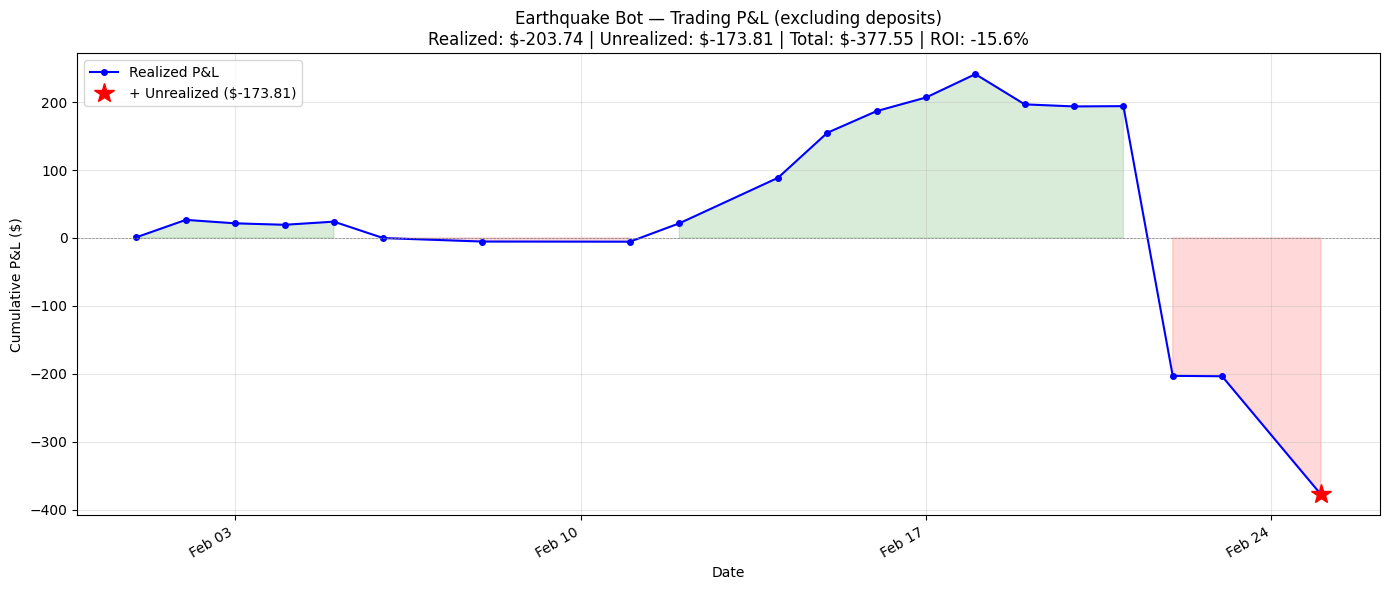


Realized P&L:   $-203.74  (186 closed trades)
Unrealized P&L: $-173.81  (7 open positions)
Total P&L:      $-377.55
ROI on deposits: -15.6%


In [5]:
# ══════════════════════════════════════════════════════════════
# TRADING P&L CHART — кумулятивная прибыль от трейдинга
# (без учёта депозитов и кэшаутов)
# ══════════════════════════════════════════════════════════════
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

# --- 1. Средняя цена входа по каждому токену (FIFO-like avg cost) ---
token_buys = defaultdict(lambda: {'total_cost': 0.0, 'total_tokens': 0.0})

# Сначала считаем avg cost из всех покупок
for t in sorted(all_trades, key=lambda x: x['timestamp']):
    asset = t.get('asset', '')
    if not asset:
        continue
    if t['type'] == 'TRADE' and t.get('side') == 'BUY':
        token_buys[asset]['total_cost'] += float(t['usdcSize'])
        token_buys[asset]['total_tokens'] += float(t['size'])

# --- 2. Для каждого sell/redeem считаем realized P&L ---
pnl_events = []  # (timestamp, realized_pnl)

for t in sorted(all_trades, key=lambda x: x['timestamp']):
    asset = t.get('asset', '')
    if not asset:
        continue
    ts = datetime.fromtimestamp(t['timestamp'], tz=timezone.utc)

    if t['type'] == 'TRADE' and t.get('side') == 'SELL':
        tokens_sold = float(t['size'])
        revenue = float(t['usdcSize'])
        info = token_buys[asset]
        if info['total_tokens'] > 0:
            avg_cost = info['total_cost'] / info['total_tokens']
            cost_of_sold = tokens_sold * avg_cost
            pnl = revenue - cost_of_sold
            pnl_events.append((ts, pnl))

    elif t['type'] == 'REDEEM':
        tokens_redeemed = float(t['size'])
        revenue = float(t['usdcSize'])
        info = token_buys[asset]
        if info['total_tokens'] > 0:
            avg_cost = info['total_cost'] / info['total_tokens']
            cost_of_redeemed = tokens_redeemed * avg_cost
            pnl = revenue - cost_of_redeemed
            pnl_events.append((ts, pnl))

# --- 3. Кумулятивный P&L ---
pnl_events.sort(key=lambda x: x[0])
cum_pnl = []
running = 0.0
for ts, pnl in pnl_events:
    running += pnl
    cum_pnl.append((ts, running))

# Добавляем текущий unrealized P&L как последнюю точку
unrealized = pm_market_value - pm_cost_basis
now = datetime.now(timezone.utc)
cum_pnl.append((now, running + unrealized))

dates = [x[0] for x in cum_pnl]
values = [x[1] for x in cum_pnl]

# --- 4. Ежедневная агрегация для cleaner chart ---
daily = defaultdict(float)
running = 0.0
for ts, pnl in pnl_events:
    day = ts.strftime('%Y-%m-%d')
    running += pnl
    daily[day] = running
# Последний день с unrealized
daily[now.strftime('%Y-%m-%d')] = running + unrealized

daily_dates = sorted(daily.keys())
daily_values = [daily[d] for d in daily_dates]
daily_dt = [datetime.strptime(d, '%Y-%m-%d') for d in daily_dates]

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(14, 6))

# Основная линия
ax.plot(daily_dt, daily_values, 'b-o', markersize=4, linewidth=1.5, label='Realized P&L')

# Зелёная/красная зоны
ax.fill_between(daily_dt, daily_values, 0,
                where=[v >= 0 for v in daily_values], alpha=0.15, color='green')
ax.fill_between(daily_dt, daily_values, 0,
                where=[v < 0 for v in daily_values], alpha=0.15, color='red')

# Unrealized P&L маркер
ax.plot(daily_dt[-1], daily_values[-1], 'g*' if daily_values[-1] >= 0 else 'r*',
        markersize=15, label=f'+ Unrealized (${unrealized:+.2f})')

ax.axhline(y=0, color='gray', linewidth=0.5, linestyle='--')
ax.set_title(f'Earthquake Bot — Trading P&L (excluding deposits)\n'
             f'Realized: ${running:+.2f} | Unrealized: ${unrealized:+.2f} | '
             f'Total: ${running + unrealized:+.2f} | ROI: {(running + unrealized)/total_deposits*100:+.1f}%',
             fontsize=12)
ax.set_ylabel('Cumulative P&L ($)')
ax.set_xlabel('Date')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# --- Summary ---
print(f'\nRealized P&L:   ${running:+.2f}  ({len(pnl_events)} closed trades)')
print(f'Unrealized P&L: ${unrealized:+.2f}  ({len(pm_positions)} open positions)')
print(f'Total P&L:      ${running + unrealized:+.2f}')
print(f'ROI on deposits: {(running + unrealized)/total_deposits*100:+.1f}%')